In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_geom_median import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
problem_spec['vector_size'] = 100
problem_spec['translation'] = "b"
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()

problem_spec['sc_theta'] = 10

problem_data['rho'] = 1.
problem_data['itr_num'] = 1000

{'n_node': 6, 'vector_size': 100, 'translation': 'b'}


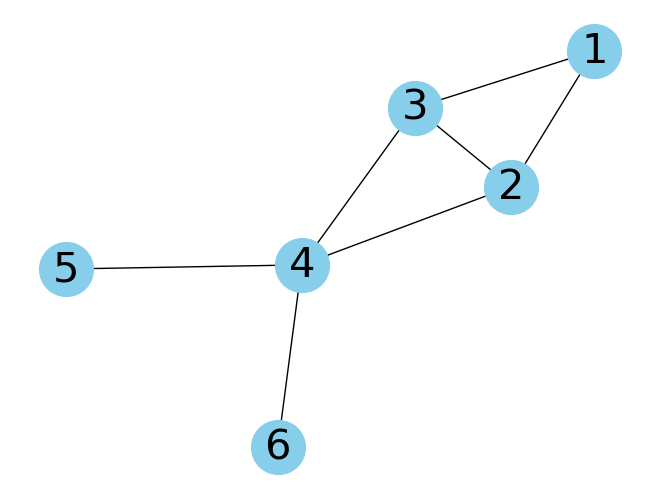

In [3]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True, font_size=30, node_size=1500)
# plt.savefig("plots/graph_n6.pdf")

In [4]:
f_star, x_opt_star = cvx_geom_median(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=3398092.2392273624, np.linalg.norm(x_opt_star)=951.3964997680573


In [5]:
b = problem_data['b']
c = problem_data['c']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
theta = problem_spec['sc_theta']
prox_operators = []
fi_operators = []

for jj in range(n_node):
    bj = b[jj*vector_size : (jj+1)*vector_size]
    cj = c[jj*vector_size : (jj+1)*vector_size]
    if jj in [3, 4]:
        prox_operators += [lambda z, rho, bj=bj, cj=cj:  prox_fj_geom_mean_sc(z, rho, bj, cj, theta=theta)]
        fi_operators += [lambda x_kj, bj=bj, cj=cj: np.linalg.norm((x_kj - bj), ord=2) + theta*np.linalg.norm(x_kj - cj, ord=2)**2]
    else:
        prox_operators += [lambda z, rho, bj=bj:  prox_fj_geom_mean(z, rho, bj)]
        fi_operators += [lambda x_kj, bj=bj: np.linalg.norm((x_kj - bj), ord=2)]

    # Testing the validity of proximals
    z = np.random.randn(vector_size)
    a = 1
    x1 = prox_fj_geom_mean(z, a, bj)
    x2 = cvx_prox_fj_geom_mean(z, a, bj, vector_size)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

    x1 = prox_fj_geom_mean_sc(z, a, bj, cj, theta=theta)
    x2 = cvx_prox_fj_geom_mean_sc(z, a, bj, cj, vector_size, theta=theta)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-3

In [6]:
R = 2
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.9914944632355156, err_opt_reldiff[-1]=1.0016229530828424
ii=200, f_reldiff[-1]=0.013773029394519302, err_opt_reldiff[-1]=0.007335709233511439
ii=400, f_reldiff[-1]=9.728507814786024e-05, err_opt_reldiff[-1]=5.3869075103885305e-05
ii=600, f_reldiff[-1]=6.848580237653608e-07, err_opt_reldiff[-1]=6.282626553678824e-06
ii=800, f_reldiff[-1]=4.854301362510163e-09, err_opt_reldiff[-1]=6.160344187738856e-06
ii=999, f_reldiff[-1]=6.847762132172793e-11, err_opt_reldiff[-1]=6.159549907725302e-06


In [7]:
# apply P-EXTRA 
# problem_data['rho'] = 0.5
problem_data['rho'] = 1
pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_dgeom_median(None, problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.9976323711703464, err_opt_reldiff[-1]=0.7503389549053779
ii=200, f_reldiff[-1]=0.24973237305948326, err_opt_reldiff[-1]=0.08835469675913933
ii=400, f_reldiff[-1]=0.03615965879371945, err_opt_reldiff[-1]=0.012071676877342421
ii=600, f_reldiff[-1]=0.00496943281359577, err_opt_reldiff[-1]=0.0016469597203022045
ii=800, f_reldiff[-1]=0.0006782873475250104, err_opt_reldiff[-1]=0.00022562212900630022
ii=999, f_reldiff[-1]=9.342083836992499e-05, err_opt_reldiff[-1]=3.230948205020382e-05


In [8]:
# params={"R":18, "Inductance":10, "Capacitance":1, "h":1.0541046971920436}
params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.9914944632355156, err_opt_reldiff[-1]=1.0016229530828424
ii=200, f_reldiff[-1]=0.001995877528081654, err_opt_reldiff[-1]=0.0010613454396367946
ii=400, f_reldiff[-1]=2.0250273260624034e-06, err_opt_reldiff[-1]=6.574591269490114e-06
ii=600, f_reldiff[-1]=2.0872027763712116e-09, err_opt_reldiff[-1]=6.15988426213471e-06
ii=800, f_reldiff[-1]=3.5775601936341536e-11, err_opt_reldiff[-1]=6.159544483189002e-06
ii=999, f_reldiff[-1]=3.3697175499570543e-11, err_opt_reldiff[-1]=6.159544139053057e-06


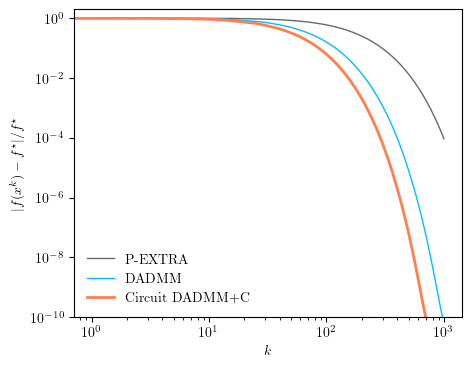

In [9]:
fname = "n6_circuit_dadmm_c_theta%s"%str(problem_spec['sc_theta'])


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' # default = 'dejavusans', other options = 'cm', 'stixsans', 'dejavuserif'
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'gold'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_f_reldiff, label='P-EXTRA', color=black, linewidth=1)
plt.plot(admm_f_reldiff, label='DADMM', color=blue, linewidth=1)
plt.plot(dadmm_c_f_reldiff, label='Circuit DADMM+C',  color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/f^\star$")
# plt.ylabel(r"$\|\tilde{\mathbf{A}}x_k\|^2_M$")
plt.ylim(1e-10, 2e-0)
plt.legend()
plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)